In [21]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

In [22]:
# Load data
real_estate_data = pd.read_csv("C:/Users/David/OneDrive - Grand Canyon University/DSC540/DataSets/housing.csv")

In [23]:
## Replacing missing total bedrooms with an average
total_bedrooms_mean = real_estate_data['total_bedrooms'].mean()
total_bedrooms_mean = math.ceil(total_bedrooms_mean)
real_estate_data['total_bedrooms'] = real_estate_data['total_bedrooms'].fillna(total_bedrooms_mean)

In [24]:
## Getting average bedrooms and rooms from household
real_estate_data['avg_bedrooms'] = real_estate_data['total_bedrooms']/real_estate_data['households']
real_estate_data['avg_rooms'] = real_estate_data['total_rooms']/real_estate_data['households']

In [25]:
## Create numerical categories for ocean proxmitiy values
ocean_dict = {"ocean_proximity": {"NEAR BAY": 1,
                                 "<1H OCEAN": 2,
                                 "INLAND": 3,
                                 "NEAR OCEAN": 4,
                                 "ISLAND": 5}}
real_estate_data.replace(ocean_dict,
                         inplace=True)

In [26]:
## remove outliers
real_estate_data[(np.abs(stats.zscore(real_estate_data)) < 10).all(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,avg_bedrooms,avg_rooms
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1,1.023810,6.984127
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1,0.971880,6.238137
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1,1.073446,8.288136
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1,1.073059,5.817352
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1,1.081081,6.281853
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,3,1.133333,5.045455
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,3,1.315789,6.114035
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,3,1.120092,5.205543
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,3,1.171920,5.329513


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


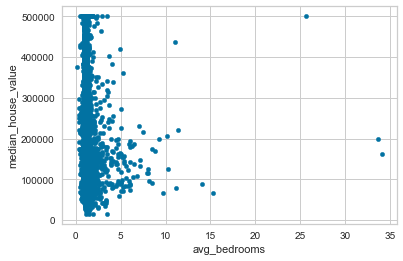

In [27]:
## Scatter plot
real_estate_data.plot.scatter(x = 'avg_bedrooms', y = 'median_house_value')
plt.show()

In [28]:
## Ocean proximity to value
real_estate_data_prox_1 = real_estate_data[real_estate_data.ocean_proximity == 1]['median_house_value']
real_estate_data_prox_2 = real_estate_data[real_estate_data.ocean_proximity == 2]['median_house_value']
real_estate_data_prox_3 = real_estate_data[real_estate_data.ocean_proximity == 3]['median_house_value']
real_estate_data_prox_4 = real_estate_data[real_estate_data.ocean_proximity == 4]['median_house_value']
real_estate_data_prox_5 = real_estate_data[real_estate_data.ocean_proximity == 5]['median_house_value']

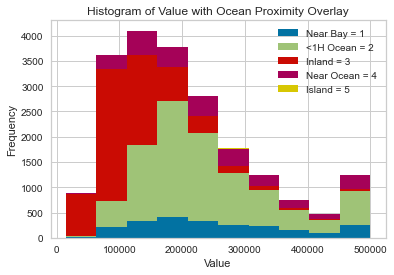

In [29]:
## Histogram 
plt.hist([real_estate_data_prox_1,
          real_estate_data_prox_2,
          real_estate_data_prox_3,
          real_estate_data_prox_4,
          real_estate_data_prox_5],
         bins = 10,
         stacked = True)
plt.legend(['Near Bay = 1',
            '<1H Ocean = 2',
            'Inland = 3',
            'Near Ocean = 4',
            'Island = 5'])
plt.title('Histogram of Value with Ocean Proximity Overlay')
plt.xlabel('Value');
plt.ylabel('Frequency');
plt.show();

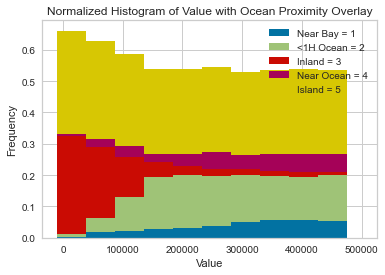

In [30]:
## Normalized ocean proximity to value
(n, bins, patches) = plt.hist([real_estate_data_prox_1,
                               real_estate_data_prox_2,
                               real_estate_data_prox_3,
                               real_estate_data_prox_4,
                               real_estate_data_prox_5],
                               bins=10,
                               stacked=True,
                               density=True)

## Creating table from variable n created in prior command
n_table = np.column_stack((n[0],
                          n[1],
                          n[2],
                          n[3],
                          n[4]))

## Normalizing the previously created table
n_norm = n_table / n_table.sum(axis=1)[:, None]

## Creating custom bins from bins variable created in preivous command
the_bins = np.column_stack((bins[0:10], bins[1:11]))
p1 = plt.bar(x=the_bins[:, 0], height=n_norm[:, 0], width=the_bins[:, 1] - the_bins[:, 0])
p2 = plt.bar(x=the_bins[:, 0], height=n_norm[:, 1], width=the_bins[:, 1] - the_bins[:, 0], bottom=n_norm[:, 0])
p3 = plt.bar(x=the_bins[:, 0], height=n_norm[:, 2], width=the_bins[:, 1] - the_bins[:, 0], bottom=n_norm[:, 1])
p4 = plt.bar(x=the_bins[:, 0], height=n_norm[:, 3], width=the_bins[:, 1] - the_bins[:, 0], bottom=n_norm[:, 2])
p5 = plt.bar(x=the_bins[:, 0], height=n_norm[:, 4], width=the_bins[:, 1] - the_bins[:, 0], bottom=n_norm[:, 3])

plt.legend(['Near Bay = 1',
            '<1H Ocean = 2',
            'Inland = 3',
            'Near Ocean = 4',
            'Island = 5'])
plt.title('Normalized Histogram of Value with Ocean Proximity Overlay')
plt.xlabel('Value');
plt.ylabel('Frequency');
plt.show();


In [31]:
## Getting X and y
X = pd.DataFrame(real_estate_data[['housing_median_age',
                                   'population',
                                   'median_income',
                                   'ocean_proximity',
                                   'avg_rooms']])
y = pd.DataFrame(real_estate_data[['median_house_value']])

In [32]:
## Finding signs of multicollinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,3.9,housing_median_age
1,2.3,population
2,5.1,median_income
3,5.9,ocean_proximity
4,6.1,avg_rooms


In [33]:
## Adding constant to X
X = sm.add_constant(X)


## Partitioning the dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)
print(X_train.head())

       const  housing_median_age  population  median_income  ocean_proximity  \
6466     1.0                34.0      1542.0         4.6211                3   
6522     1.0                27.0      3481.0         2.4875                2   
5163     1.0                39.0      1463.0         1.5294                2   
13135    1.0                21.0       988.0         4.3500                3   
1474     1.0                26.0      1174.0         2.9861                1   

       avg_rooms  
6466    5.525532  
6522    3.457300  
5163    3.651226  
13135   5.936877  
1474    4.310646  


Predictions:
 [[175164.25474755]
 [144860.69278363]
 [186665.87477622]
 [119863.18034396]
 [242068.58110946]]
Coefficients: 
 [[ 0.00000000e+00  1.52415218e+03  1.44158073e+00  4.36771874e+04
  -1.10224831e+04 -3.16992811e+03]]
Mean squared error: 6239608595.33
Coefficient of determination: 0.53


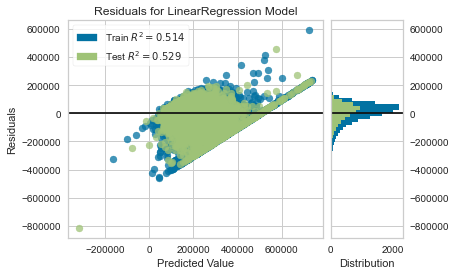

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [34]:
## Creating model using scikits LinearRegression()
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
print("Predictions:\n", predictions[0:5])
print("Coefficients: \n", lm.coef_)
print("Mean squared error of Linear Regression: %.2f" % mean_squared_error(y_test, predictions))
print("R2 score for Linear Regression: %.2f" % r2_score(y_test, predictions))


res_plot = ResidualsPlot(lm)

res_plot.fit(X_train, y_train)  
res_plot.score(X_test, y_test)  
res_plot.show() 

In [35]:
## Creating model using statsmodel using OLS()
model_train = sm.OLS(y_train,
                     X_train).fit()
model_train.summary()

model_test = sm.OLS(y_test,
                     X_test).fit()
model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1181.
Date:                Wed, 03 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:27:47   Log-Likelihood:                -65487.
No. Observations:                5160   AIC:                         1.310e+05
Df Residuals:                    5154   BIC:                         1.310e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.448e+04   6415.561      2.257      0.024    1905.309    2.71e+04
housing_median_age  1727.1017     93.727     18.427      0.000    1543.357    1910.847
population             3.2659      1.075      3.039      0.002       1.159       5.372
median_income       4.289e+04    606.733     70.692      0.000    4.17e+04    4.41e+04
ocean_proximity    -9827.8613   1327.589     -7.403      0.000   -1.24e+04   -7225.223
avg_rooms           -428.2285    413.087     -1.037      0.300   -1238.054     381.597
==============================================================================
Omnibus:                      926.764   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1904.229
Skew:                           1.067   Prob(JB):                         0.00
Kurtosis:                       5.074   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     3278.
Date:                Wed, 03 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:27:47   Log-Likelihood:            -1.9682e+05
No. Observations:               15480   AIC:                         3.937e+05
Df Residuals:                   15474   BIC:                         3.937e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.609e+04   3899.570      9.254      0.000    2.84e+04    4.37e+04
housing_median_age  1524.1522     56.634     26.913      0.000    1413.144    1635.161
population             1.4416      0.595      2.421      0.015       0.274       2.609
median_income       4.368e+04    371.179    117.672      0.000    4.29e+04    4.44e+04
ocean_proximity    -1.102e+04    790.393    -13.946      0.000   -1.26e+04   -9473.220
avg_rooms          -3169.9281    298.862    -10.607      0.000   -3755.733   -2584.123
==============================================================================
Omnibus:                     3454.501   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8828.748
Skew:                           1.216   Prob(JB):                         0.00
Kurtosis:                       5.787   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
## MAEBaseline and MAEReression
ypred = model_train.predict(X_test)
print('=============OLS results=============')
print('================Mean=================')
print(y_test.mean())
print('================MAE==================')
print(mae(y_test.values, predictions))
print('================MSE==================')
print(model_train.mse_total)

==============Mean==============
median_house_value    208017.006395
dtype: float64
==============MAE==============
58957.81998106629
==============MSE==============
13334008481.371748


In [38]:
print(y_test.sum())

median_house_value    1.073368e+09
dtype: float64


In [39]:
print(ypred.sum())

1065546888.8921914
